In [11]:
import pandas as pd
import numpy as np
import seaborn as sns

from tools_analysis import *

sns.set_theme()

In [12]:
folder_path = "../study"
stats_path = folder_path + "/stats"

In [13]:
# Reading the whole dataset
df = pd.read_csv("%s/dataset_thres1.csv" % stats_path, index_col="ID")
print(df.shape)
# # Removing the healty subjects
# df.dropna(axis=0, how="any", inplace=True) 
# print(df.shape)

info = df.columns[:10]
df[info] = df[info].astype(int)

df = df.drop("VNSLC_16") # remove it because doesn't have the tracts from freesurfer, if I comment it, all the TRACULA tracts will be removed
df = df.dropna(axis=1) # remove NaN features
df = df.drop(df.filter(regex=r'(min|max)'), axis=1) # remove max and min features because are full of imperfections
df = df.drop(df.filter(regex=r'(std|skew|kurt|nTracts)'), axis=1) # remove them beacuse they have an high variability and difficult to interpretare (only kurt)
df = df.loc[:, (abs(df - df.iloc[0]) > 1e-12).any()] # Removing almost constant features
print(df.shape)

X = df.drop(["resp", "respPart"], axis=1)
y = df["resp"]

(19, 7528)
(18, 1868)


# Logistic Regression

#### Scaling pruning

In [4]:
# Scaling pruning 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler()]:
    print(scaler.__class__.__name__)
    
    run_log_reg_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )

StandardScaler
F1: 0.733 | Pr: 0.813 | Re: 0.972 | AUC: 0.677 | Accuracy: 0.645 

MinMaxScaler
F1: 0.734 | Pr: 0.817 | Re: 0.971 | AUC: 0.683 | Accuracy: 0.648 

Normalizer
F1: 0.704 | Pr: 0.742 | Re: 0.990 | AUC: 0.470 | Accuracy: 0.581 

Normalizer
F1: 0.704 | Pr: 0.740 | Re: 0.990 | AUC: 0.468 | Accuracy: 0.580 

RobustScaler
F1: 0.715 | Pr: 0.800 | Re: 0.960 | AUC: 0.628 | Accuracy: 0.620 



the best scaler is the standard scaler

#### Hyper parm pruning

In [24]:
# Hyper-parameters pruning

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

param_grid = {
    "logisticregression__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    LogisticRegression(
        penalty="l2",
        dual=True,
        class_weight="balanced",
        random_state=7,
        solver="liblinear",
        max_iter=100000,
    )
)

gridSearchF1 = GridSearchCV(
    pipe,
    param_grid,
    scoring="f1",
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearchF1.fit(X, y)

gridSearchAUC = GridSearchCV(
    pipe,
    param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearchAUC.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced',
                                                           dual=True,
                                                           max_iter=100000,
                                                           random_state=7,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [1.0, 0.5, 0.1, 0.05, 0.01,
                                                   0.005, 0.001, 0.0005, 0.0001,
                                                   5e-05, 1e-05, 5e-06,
                                                   1e-06]},
             scoring='roc_auc')

In [27]:
print("f1 score")
print(gridSearchF1.cv_results_["mean_test_score"])
print(gridSearchF1.cv_results_["std_test_score"])
print(gridSearchF1.cv_results_["rank_test_score"])
print("roc_auc score")
print(gridSearchAUC.cv_results_["mean_test_score"])
print(gridSearchAUC.cv_results_["std_test_score"])
print(gridSearchAUC.cv_results_["rank_test_score"])

f1 score
[0.6500127  0.6500127  0.6500127  0.6500127  0.6500127  0.6500127
 0.7035127  0.73449524 0.72377619 0.72377619 0.72377619 0.72377619
 0.72377619]
[0.21285172 0.21285172 0.21285172 0.21285172 0.21285172 0.21285172
 0.20095256 0.17746096 0.19769102 0.19769102 0.19769102 0.19769102
 0.19769102]
[8 8 8 8 8 8 7 1 2 2 2 2 2]
roc_auc score
[0.6625   0.6625   0.6625   0.6625   0.6625   0.6625   0.68475  0.759875
 0.79375  0.79375  0.79375  0.79375  0.79375 ]
[0.19976549 0.19976549 0.19976549 0.19976549 0.19976549 0.19976549
 0.19483631 0.21068189 0.22190581 0.22190581 0.22190581 0.22190581
 0.22190581]
[8 8 8 8 8 8 7 6 1 1 1 1 1]


[1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

A good trade-off could be 1e-4. AUC := 0.725, f1 := 0.788 (Standard Scaler) 

Ho provato con normalizer l1 è le prestazioni non sono buone quante lo standard scaler.

#### Scalar pruning with best hyperparameter

In [20]:
# Scaling pruning with best hyperparameter

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler()]:
    print(scaler.__class__.__name__)
    
    run_log_reg_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        C=1e-4,
        )

StandardScaler
F1: 0.786 | Pr: 0.884 | Re: 0.990 | AUC: 0.789 | Accuracy: 0.725 

MinMaxScaler
F1: 0.784 | Pr: 0.879 | Re: 0.991 | AUC: 0.784 | Accuracy: 0.721 

Normalizer
F1: 0.704 | Pr: 0.741 | Re: 0.990 | AUC: 0.469 | Accuracy: 0.581 

Normalizer
F1: 0.704 | Pr: 0.742 | Re: 0.989 | AUC: 0.472 | Accuracy: 0.581 

RobustScaler
F1: 0.778 | Pr: 0.865 | Re: 0.993 | AUC: 0.768 | Accuracy: 0.710 



#### Sequential Feature Selection

Here launch the feature selection in seqFeatureSelec.py with the tuned parameters.

Check the performance with the selected features

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

print("l2")
run_log_reg_cv(
        df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']], 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=StandardScaler(),
        alpha=100,
        penalty="l2"
        )

l2
F1: 0.857 | Pr: 1.000 | Re: 1.000 | AUC: 1.000 | Accuracy: 0.857 



SGDClassifier(alpha=100, loss='log_loss', n_jobs=-1)

#### Feature Weights

In [7]:
import eli5
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']],
    df["resp"],
    test_size=1/3,
    random_state=7,
    shuffle=True,
    stratify=df["resp"]
)

pipe = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss = 'log_loss',
                         n_jobs = -1, 
                         penalty = 'l2', 
                         alpha=100,
                         max_iter=10000
    )
)

pipe.fit(X_train, y_train)

eli5.show_weights(pipe, feature_names=X_train.columns)

Weight?,Feature
+0.002,acomm_icvf_mean
+0.001,epilepsy_duration
+0.000,acomm_fvf_tot_mean
-0.001,acomm_fbundle_mean
-0.002,epilepsy_type
-0.002,acomm_fextra_mean
-0.003,acomm_MD_mean
-0.003,cc.bodyt_frac_csf_mf_mean
-0.003,acomm_AD_mean
-0.004,right-fornix_RD_mean


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


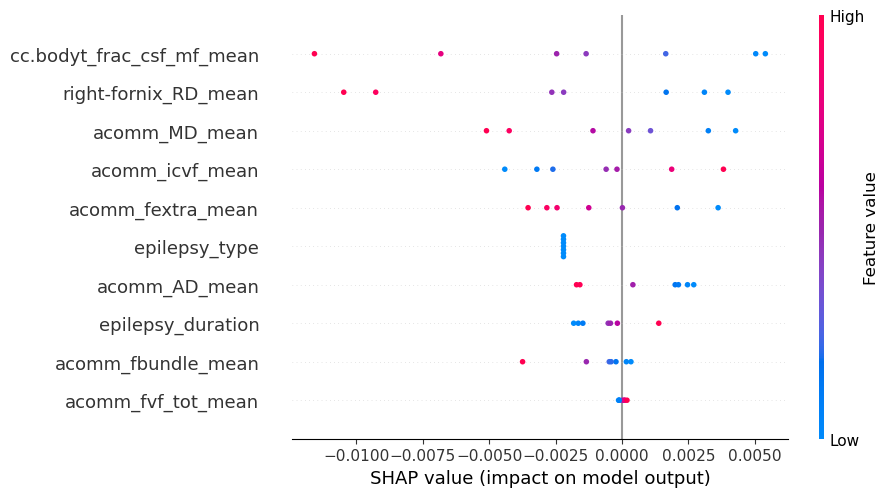

In [8]:
import shap
shap.initjs()
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']],
    df["resp"],
    test_size=1/3,
    random_state=7,
    shuffle=True,
    stratify=df["resp"]
)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

logReg = SGDClassifier(
    loss = 'log_loss',
    n_jobs = -1, 
    penalty = 'l2', 
    alpha=50,
    max_iter=10000
)

logReg.fit(X_train, y_train)

explainer = shap.Explainer(logReg, X_train, feature_names=df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']].columns)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())

In [15]:
shap.plots.force(shap_values[0])

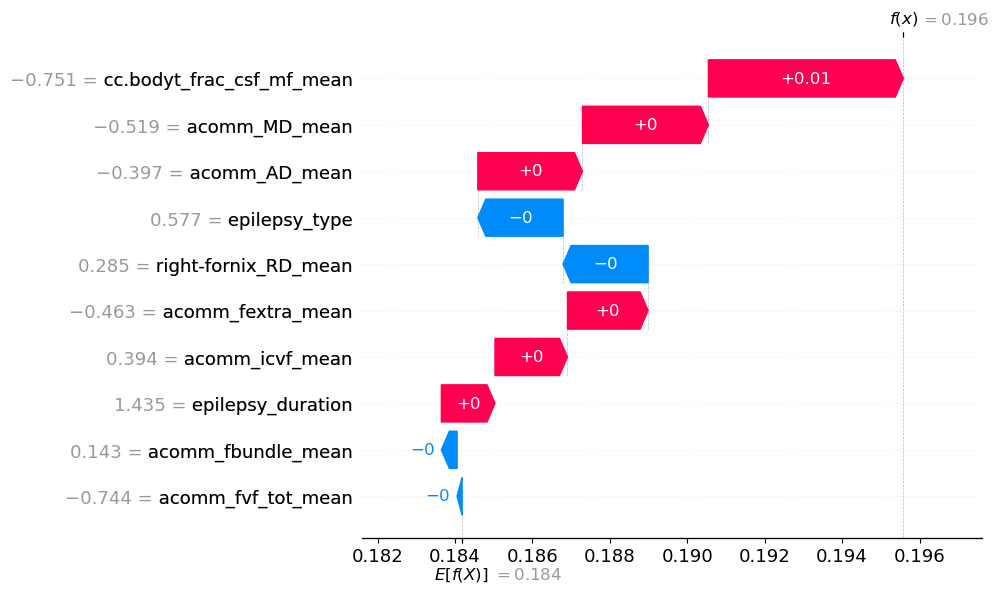

In [16]:
shap.plots.waterfall(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


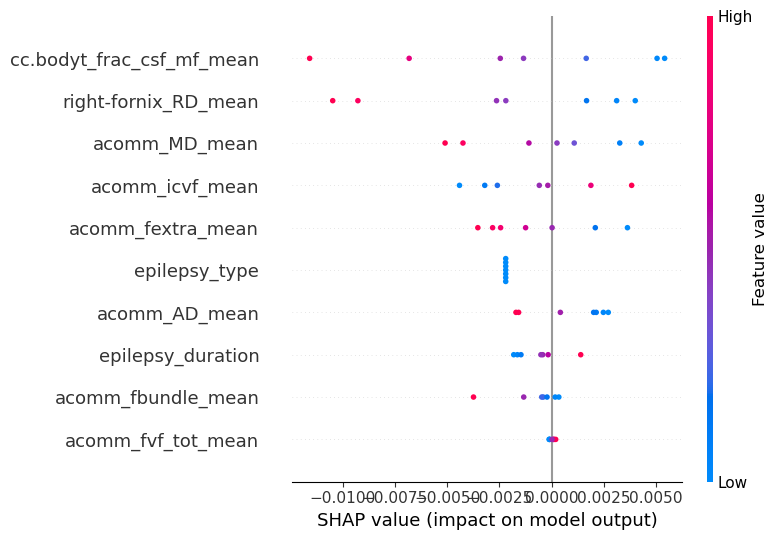

In [17]:
shap.summary_plot(shap_values, X_test)

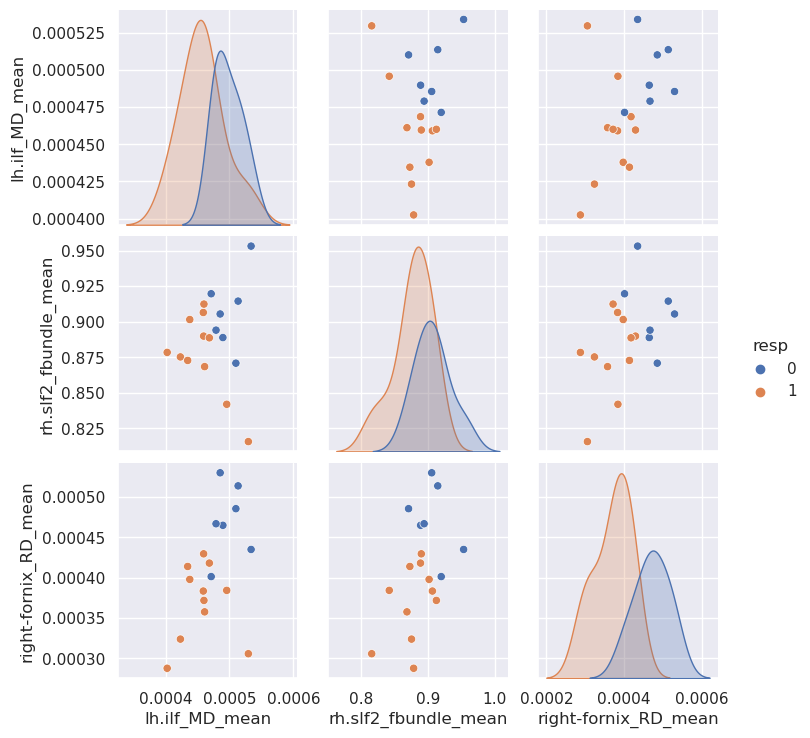

In [52]:
toPlot = ['lh.ilf_MD_mean', 'rh.slf2_fbundle_mean', 'right-fornix_RD_mean']
ax = sns.pairplot(df, hue="resp", x_vars=toPlot, y_vars=toPlot)

# SVM

#### Scaling pruning

In [5]:
# Scaling pruning 

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler()]:
    print(scaler.__class__.__name__)
    
    run_svm_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        penalty="l2"
        )

StandardScaler
F1: 0.730 | Pr: 0.808 | Re: 0.972 | AUC: 0.662 | Accuracy: 0.640 

MinMaxScaler
F1: 0.726 | Pr: 0.802 | Re: 0.972 | AUC: 0.652 | Accuracy: 0.633 

Normalizer
F1: 0.704 | Pr: 0.741 | Re: 0.990 | AUC: 0.469 | Accuracy: 0.581 

Normalizer
F1: 0.704 | Pr: 0.742 | Re: 0.989 | AUC: 0.472 | Accuracy: 0.581 

RobustScaler
F1: 0.711 | Pr: 0.792 | Re: 0.960 | AUC: 0.609 | Accuracy: 0.612 



the best scaler is the MinMaxScaler(), but the results are very similat to StandardScaler, therefore we will use standardScaler to maintain the same scaler.

#### Hyper parm pruning

In [25]:
# Hyper-parameters pruning

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline

param_grid = {
    "linearsvc__C" : [1e0, 5e-1, 1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
}

pipe = make_pipeline(
    StandardScaler(), 
    LinearSVC(
            penalty="l2",
            loss="hinge",
            dual=True,
            class_weight="balanced",
            random_state=7,
            max_iter=100000,
    )
)

gridSearchF1 = GridSearchCV(
    pipe,
    param_grid,
    scoring="f1",
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearchF1.fit(X, y)

gridSearchAUC = GridSearchCV(
    pipe,
    param_grid,
    scoring="roc_auc",
    n_jobs=-1,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
)

gridSearchAUC.fit(X, y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=7,
            test_size=0.3333333333333333, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearsvc',
                                        LinearSVC(class_weight='balanced',
                                                  loss='hinge', max_iter=100000,
                                                  random_state=7))]),
             n_jobs=-1,
             param_grid={'linearsvc__C': [1.0, 0.5, 0.1, 0.05, 0.01, 0.005,
                                          0.001, 0.0005, 0.0001, 5e-05, 1e-05,
                                          5e-06, 1e-06]},
             scoring='roc_auc')

In [26]:
print("f1 score")
print(gridSearchF1.cv_results_["mean_test_score"])
print(gridSearchF1.cv_results_["std_test_score"])
print(gridSearchF1.cv_results_["rank_test_score"])
print("roc_auc score")
print(gridSearchAUC.cv_results_["mean_test_score"])
print(gridSearchAUC.cv_results_["std_test_score"])
print(gridSearchAUC.cv_results_["rank_test_score"])

f1 score
[0.6500127  0.6500127  0.6500127  0.6500127  0.6500127  0.6500127
 0.7035127  0.73449524 0.72377619 0.72377619 0.72377619 0.72377619
 0.72377619]
[0.21285172 0.21285172 0.21285172 0.21285172 0.21285172 0.21285172
 0.20095256 0.17746096 0.19769102 0.19769102 0.19769102 0.19769102
 0.19769102]
[8 8 8 8 8 8 7 1 2 2 2 2 2]
roc_auc score
[0.6625   0.6625   0.6625   0.6625   0.6625   0.6625   0.68475  0.759875
 0.79375  0.79375  0.79375  0.79375  0.79375 ]
[0.19976549 0.19976549 0.19976549 0.19976549 0.19976549 0.19976549
 0.19483631 0.21068189 0.22190581 0.22190581 0.22190581 0.22190581
 0.22190581]
[8 8 8 8 8 8 7 6 1 1 1 1 1]


In [23]:
# Scaling pruning with best hyperparameter

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler()]:
    print(scaler.__class__.__name__)
    
    run_svm_cv(
        X, 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        C=5e-3,
        penalty="l2"
        )

StandardScaler
F1: 0.730 | Pr: 0.808 | Re: 0.972 | AUC: 0.662 | Accuracy: 0.640 

MinMaxScaler
F1: 0.778 | Pr: 0.873 | Re: 0.987 | AUC: 0.791 | Accuracy: 0.713 

Normalizer
F1: 0.704 | Pr: 0.741 | Re: 0.990 | AUC: 0.469 | Accuracy: 0.581 

Normalizer
F1: 0.704 | Pr: 0.742 | Re: 0.989 | AUC: 0.472 | Accuracy: 0.581 

RobustScaler


KeyboardInterrupt: 

#### Sequential Feature Selection

Here launch the feature selection in seqFeatureSelec.py with the tuned parameters.

Check the performance with the selected features

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

print("l2")
run_log_reg_cv(
        df[['epilepsy_type', 'epilepsy_duration', 'acomm_AD_mean', 'acomm_MD_mean', 'acomm_fbundle_mean', 'acomm_fextra_mean', 'acomm_fvf_tot_mean', 'acomm_icvf_mean', 'cc.bodyt_frac_csf_mf_mean', 'right-fornix_RD_mean']], 
        y,
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=StandardScaler(),
        alpha=500,
        penalty="l2"
        )